In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

In [70]:
# loading the data and doing a sanity check to make sure all necessary columns are present
branded_df = pd.read_csv("../DATA/processed/branded_food_clean.csv")
branded_df = branded_df.head(1000)

expected_cols = {'fdc_id', 'product_name', 'ingredients_list_json', 'num_ingredients'}

missing_cols = expected_cols - set(branded_df.columns)

if missing_cols:
  print(f"Missing columns: {missing_cols}")
else:
  print("All expected columns are present")

All expected columns are present


In [71]:
def parse_json(json_record):
  if pd.isna(json_record):
    return []

  record =  str(json_record).strip()

  if record.startswith('[') and record.endswith(']'):
    try:
            items = json.loads(record)
    except Exception:
            items = record.split(',')

  else:
    items = record.split(',')

  norm = []
  for it in items:
        tok = re.sub(r"^ingredients\s*:\s*", "", str(it), flags=re.IGNORECASE).strip().lower()
        # remove 'made from...' or 'made with...' and everything after it
        tok = re.sub(r"\bmade\s+(from|with)\b.*", "", tok).strip()
        # keep only letters, digits, %, spaces, and hyphens
        tok = re.sub(r"[^a-z0-9%\s\-]", " ", tok)
        tok = re.sub(r"\s+", " ", tok).strip()
        if tok:
            norm.append(tok)
  return norm

branded_df['ingredients_list'] = branded_df['ingredients_list_json'].apply(parse_json)


In [72]:
def rank_weight(rank, alpha = 0.6, scale = 1.0):
  return scale / (rank ** alpha)

def order_weight_tokens(ing_list, alpha=0.6, scale=6):
    """
    Create a string where earlier ingredients are repeated more often.
    alpha controls how quickly weight decays with rank.
    scale controls how many repetitions the first ingredient gets.
    """
    bag = []
    for rank, item in enumerate(ing_list, start=1):
        weight = 1 / (rank ** alpha)  # position decay
        reps = max(1, int(weight * scale))  # repeat token
        bag.extend([item] * reps)
    return " , ".join(bag)

branded_df['ordered_text'] = branded_df['ingredients_list'].apply(order_weight_tokens)


def lf_any(tokens, pattern, base_weight=1.0, alpha=0.6):
    pat = re.compile(pattern)
    score = 0.0
    for i, t in enumerate(tokens, start=1):
        if pat.search(t):
            score += base_weight * rank_weight(i, alpha=alpha)
    return score

LFs_negative = {
    # Colors / dyes (incl. Red No. 3)
    "artificial_colors": (r"\b(red\s*0*3|red\s*no\.?\s*3|red\s*3|yellow\s*5|yellow\s*6|blue\s*1|artificial color|artificial colours?)\b", 1.2),
    # Titanium dioxide
    "titanium_dioxide": (r"\btitanium\s+dioxide\b", 1.5),
    # Potassium bromate
    "potassium_bromate": (r"\bpotassium\s+bromate\b", 1.6),
    # Brominated vegetable oil
    "bvo": (r"\bbrominated\s+vegetable\s+oil\b", 1.6),
    # Parabens (incl. propylparaben)
    "parabens": (r"\b(parabens?|propylparaben|methylparaben|butylparaben)\b", 1.2),
    # High fructose / corn syrup / added sugars cluster
    "hfcs_syrups_sugars": (r"\b(high\s*fructose\s*corn\s*syrup|hfcs|corn\s*syrup|glucose[-\s]*fructose|invert\s*sugar|sucrose|dextrose|fructose|glucose|molasses)\b", 1.4),
    # Nitrites/nitrates
    "nitrites": (r"\b(sodium|potassium)\s+(nitrite|nitrate)s?\b", 1.3),
    # TBHQ / BHA / BHT antioxidants
    "synthetic_antioxidants": (r"\b(tbhq|tertiary\s*butylhydroquinone|bha|butylated\s*hydroxyanisole|bht|butylated\s*hydroxytoluene)\b", 1.3),
    # Artificial sweeteners
    "non_nutritive_sweeteners": (r"\b(aspartame|acesulfame\s*k?|acesulfamek|sucralose|saccharin|neotame|advantame)\b", 1.2),
    # Hydrogenated/shortening (often avoided; reasonable to include)
    "hydrogenated_fats": (r"\b(partially\s+)?hydrogenated\b|\bshortening\b", 1.4),
}

def score_negative(tokens, alpha = 0.6):
  s = 0.0
  for _, (pat, w) in LFs_negative.items():
      s += lf_any(tokens, pat, base_weight=w, alpha=alpha)
  return s


LFs_positive = {
    "whole_grain_first": (r"\b(whole\s+grain|whole[-\s]*wheat|whole\s*oats?|whole\s*rye|whole\s*barley)\b", 1.2),
     "fresh_produce": (r"\b("
                      r"apple|apples|banana|bananas|berry|berries|blueberry|strawberry|raspberry|blackberry|"
                      r"cherry|cherries|grape|grapes|melon|cantaloupe|honeydew|watermelon|mango|mangos|pineapple|pear|pears|"
                      r"peach|peaches|plum|plums|kiwi|oranges?|clementine|tangerine|lemon|lime|"
                      r"spinach|kale|lettuce|romaine|arugula|chard|collard|broccoli|cauliflower|cabbage|"
                      r"carrot|carrots|celery|beet|beets|radish|radishes|turnip|turnips|"
                      r"onion|onions|garlic|ginger|leek|shallot|scallion|"
                      r"pepper|peppers|bell\s*pepper|tomato|tomatoes|cucumber|zucchini|squash|"
                      r"pumpkin|eggplant|brussels\s*sprouts|asparagus|spinach"
                      r")\b", 1.0),
    "protein": (r"\b("
                r"protein|chicken|beef|pork|turkey|lamb|duck|salmon|tuna|cod|trout|shrimp|prawn|"
                r"crab|lobster|fish|anchovy|sardine|mackerel|egg|eggs|egg\s*white|egg\s*yolk|"
                r"tofu|tempeh|seitan|soy\s*protein|pea\s*protein|whey\s*protein|casein"
                r")\b", 1.0),
    "legumes": (r"\b("
                r"lentil|lentils|chickpea|chickpeas|pea|peas|split\s*peas|black\s*eyed\s*peas|"
                r"legume|legumes"
                r")\b", 0.8),
    "beans": (r"\b("
              r"black\s*bean|black\s*beans|kidney\s*bean|kidney\s*beans|pinto\s*bean|pinto\s*beans|"
              r"navy\s*beans|white\s*beans|cannellini|garbanzo|refried\s*beans|soybeans?|edamame"
              r")\b", 0.8),
    "nuts": (r"\b("
             r"almond|almonds|walnut|walnuts|cashew|cashews|pecan|pecans|pistachio|pistachios|"
             r"hazelnut|hazelnuts|macadamia|macadamias|brazil\s*nuts?|chestnut|chestnuts"
             r")\b", 0.8)
}

def score_positive(tokens, alpha = 0.6):
  s = 0.0
  for _, (pat, w) in LFs_positive.items():
    s += lf_any(tokens, pat, base_weight=w, alpha=alpha)
  return s

def length_penalty(tokens, cutoff = 12, per_extra = 0.03):
  extra = max(0, len(tokens) - cutoff)
  return extra * per_extra


In [73]:
def weak_score(tokens, alpha=0.6):
  base = score_negative(tokens, alpha=alpha) - 0.9 * score_positive(tokens, alpha=alpha)
  return base + length_penalty(tokens)


def score_to_label(score, t_healthy = -0.5, t_unhealthy = -0.1):
  if score < t_healthy:
    return 'healthy'
  elif score > t_unhealthy:
    return 'unhealthy'
  else:
    return 'intermediate'

def apply_snorkel_labels(df, ing_col="ingredients_list", alpha=0.6,
                         t_healthy=None, t_unhealthy=None, use_quantiles=True):
    df = df.copy()
    df["weak_score"] = df[ing_col].apply(lambda lst: weak_score(lst, alpha=alpha))
    if use_quantiles:
        q_low, q_high = df["weak_score"].quantile([0.33, 0.67])
        t_healthy = q_low if t_healthy is None else t_healthy
        t_unhealthy = q_high if t_unhealthy is None else t_unhealthy
    elif t_healthy is None or t_unhealthy is None:
        # sensible fallbacks
        t_healthy, t_unhealthy = -0.4, 0.6
    df["label"] = df["weak_score"].apply(lambda s: score_to_label(s, t_healthy, t_unhealthy))
    return df, {"t_healthy": t_healthy, "t_unhealthy": t_unhealthy}


labeled_df, thresholds = apply_snorkel_labels(branded_df, ing_col="ingredients_list", alpha=0.6)
print(thresholds)
binary_df = labeled_df[labeled_df['label'] != 2].copy()

{'t_healthy': -0.7219577166193093, 't_unhealthy': 0.0}


In [74]:
# Threshold Tuning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

import warnings
from sklearn.exceptions import ConvergenceWarning

def relabel(df, th, tu, alpha=0.6):
    new_df, _ = apply_snorkel_labels(df, ing_col="ingredients_list",
                                     alpha=alpha, t_healthy=th, t_unhealthy=tu,
                                     use_quantiles=False)
    return new_df

def quick_f1(df):
    X = df["ordered_text"].fillna("").astype(str)
    y = df["label"].astype(str)
    m = X.str.strip().str.len() > 0
    X, y = X[m], y[m]
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, token_pattern=r"(?u)\b\w+\b")),
        ("lr", LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", n_jobs=-1)),
    ])

    # Ignore noisy warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        pipe.fit(X_tr, y_tr)
        y_hat = pipe.predict(X_va)
        
    return f1_score(y_va, pipe.predict(X_va), average="macro", zero_division=0)

# small search (fast). tweak ranges if needed.
best = (-1, None, None)
for th in np.linspace(-1.2, -0.1, 8):   # t_healthy candidates
    for tu in np.linspace(0.0, 0.8, 8): # t_unhealthy candidates
        f1 = quick_f1(relabel(branded_df, th, tu, alpha=0.6))
        if f1 > best[0]:
            best = (f1, th, tu)

print(f"[tuning] best macro-F1={best[0]:.3f} at t_healthy={best[1]:.3f}, t_unhealthy={best[2]:.3f}")

# use the tuned thresholds for the rest of the notebook
labeled_df, _ = apply_snorkel_labels(branded_df, ing_col="ingredients_list",
                                     alpha=0.6, t_healthy=best[1], t_unhealthy=best[2],
                                     use_quantiles=False)


[tuning] best macro-F1=0.872 at t_healthy=-0.414, t_unhealthy=0.114


In [75]:
multi_df = labeled_df.copy()

# features and labels
X = multi_df["ordered_text"].fillna("")
y = multi_df["label"]   # {'healthy','intermediate','unhealthy'}

mask = X.str.strip().str.len() > 0
X, y = X[mask], y[mask]

print("Class counts:", y.value_counts().to_dict())

# Split of three classes
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
rel_val = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=rel_val, stratify=y_temp, random_state=42
)

Class counts: {'intermediate': 416, 'healthy': 411, 'unhealthy': 173}


In [76]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3,
                              token_pattern=r"(?u)\b\w+\b")),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 20, 40],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
}

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring="f1_macro",   # or "f1_weighted"
    n_jobs=-1, verbose=1, error_score="raise"
)

grid.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}
Best CV f1_macro: 0.7998905768676055
              precision    recall  f1-score   support

     healthy       0.84      0.85      0.85        62
intermediate       0.78      0.79      0.78        62
   unhealthy       0.88      0.81      0.84        26

    accuracy                           0.82       150
   macro avg       0.83      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



Test Accuracy: 0.82
Test F1 (macro): 0.824

Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.85      0.85        62
intermediate       0.78      0.79      0.78        62
   unhealthy       0.88      0.81      0.84        26

    accuracy                           0.82       150
   macro avg       0.83      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



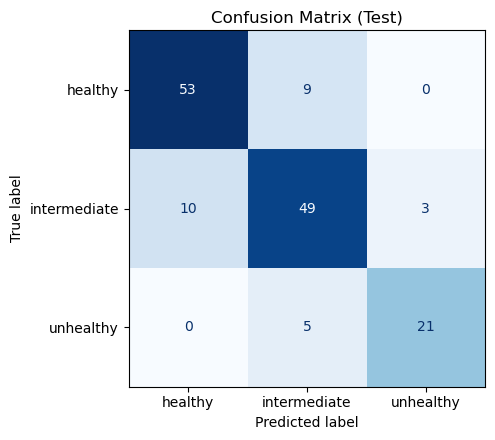

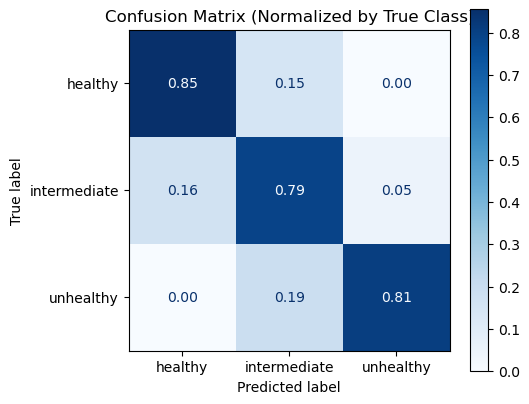

Saved figures to: C:\Users\nifft\Downloads\DS[4002] Project1\OUTPUT


In [77]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
from pathlib import Path

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# scores
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (macro):", f1_score(y_test, y_pred, average="macro", zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# confusion matrix  (counts)
labels = ["healthy", "intermediate", "unhealthy"]  # ensure consistent order
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(5.5, 4.5))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Confusion Matrix (Test)")
plt.tight_layout()

# save file
outdir = Path("../OUTPUT"); outdir.mkdir(parents=True, exist_ok=True)
fig.savefig(outdir / "confusion_matrix_counts.png", dpi=300, bbox_inches="tight")
plt.show()

# Normalized confusion matrix 
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")  # rows sum to 1
fig2, ax2 = plt.subplots(figsize=(5.5, 4.5))
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
disp2.plot(ax=ax2, cmap="Blues", values_format=".2f", colorbar=True)
ax2.set_title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()

# save file
fig2.savefig(outdir / "confusion_matrix_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved figures to:", outdir.resolve())
